In [1]:
import pandas as pd
import sklearn
from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import HdpModel
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
import pickle

from utils import *

In [2]:
# set true if use pre-trained, pre-process data pickle
is_use_pre_run = False

In [3]:
bp = "/home/hung/ws/data/raf-db"
df = pd.read_csv("{}/data_aligned.csv".format(bp))
df_train = df.loc[df['name'].str.contains('train_')]
df_test = df.loc[df['name'].str.contains('test_')]
fname_train = ["{}/{}".format(bp, o) for o in df_train['name']]
fname_test = ["{}/{}".format(bp, o) for o in df_test['name']]
labels_train = [o for o in df_train['label']]
labels_test = [o for o in df_test['label']]

In [4]:
# fname_train, labels_train = balanced_subsample(np.array(fname_train), np.array(labels_train), 1)

In [5]:
# [len(labels_train[(labels_train==i)]) for i in range(1, 8)]

In [6]:
classes = np.array(['NU', 'Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger', 'Neutral'], dtype=str)

In [7]:
suft_npy = download_and_cache(GDRIVE_SUFT_100_NORM_ID)
sift_npy = download_and_cache(GDRIVE_SIFT_100_NORM_ID)
kaze_npy = download_and_cache(GDRIVE_KAZE_100_NORM_ID)

if is_use_pre_run:
    docs_data_pkl = download_and_cache(GDRIVE_DOCS_DATA)
    bow_svm_clf_pkl = download_and_cache(GDRIVE_BOW_SVM_CLF)
    hdp_svm_clf_pkl = download_and_cache(GDRIVE_HDP_SVM_CLF)

In [8]:
vocab = Vocab(suft_npy, sift_npy, kaze_npy)

In [9]:
# one time, later load from docs_data_pkl
if not is_use_pre_run:
    train_docs, train_targets = build_docs(vocab, fname_train, labels_train)
    test_docs, test_targets = build_docs(vocab, fname_test, labels_test)
    
    # save to use later
    docs_data = train_docs, train_targets, test_docs, test_targets
    with open('docs-data.pkl', 'wb') as f:
        pickle.dump(docs_data, f)

In [10]:
# load pre_run docs_data
if is_use_pre_run:
    with open(docs_data_pkl, 'rb') as f:
        docs_data = pickle.load(f)

In [11]:
train_docs, train_targets, test_docs, test_targets = docs_data

In [12]:
X_train_tf, train_targets = build_tf_idf_docs(train_docs, train_targets)
X_test_tf, test_targets = build_tf_idf_docs(test_docs, test_targets)

### NB

In [13]:
clf = MultinomialNB().fit(X_train_tf, train_targets)
predicted = clf.predict(X_test_tf)
np.mean(predicted == test_targets) 

0.4181639986932375

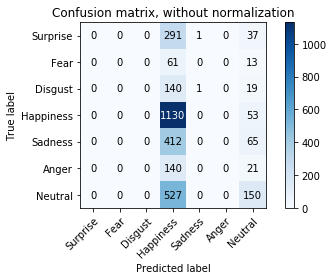

In [14]:
_ = plot_confusion_matrix(test_targets, predicted, classes)

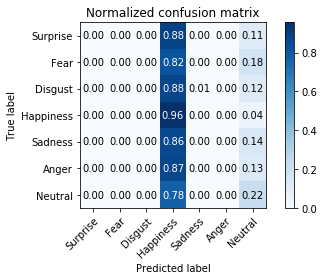

In [15]:
_ = plot_confusion_matrix(test_targets, predicted, classes, normalize=True)

### SVM

In [16]:
if is_use_pre_run:
    with open(bow_svm_clf_pkl, 'rb') as f:
        clf1 = pickle.load(f)
else:
    clf1 = svm.SVC(gamma='scale', coef0=4).fit(X_train_tf, train_targets)
    with open('bow_svm_clf.pkl', 'wb') as f:
        pickle.dump(clf1, f)

In [17]:
predicted = clf1.predict(X_test_tf)
np.mean(predicted == test_targets)  

0.4900359359686377

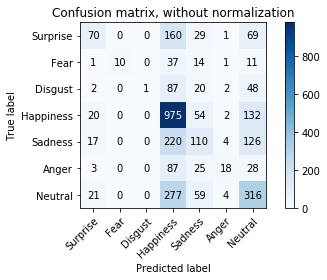

In [18]:
plot_confusion_matrix(test_targets, predicted, classes, normalize=False)

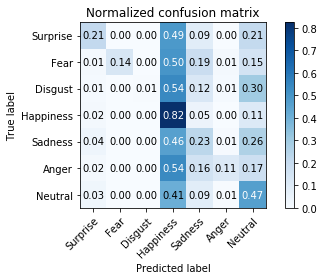

In [19]:
plot_confusion_matrix(test_targets, predicted, classes, normalize=True)

### RF

In [20]:
clf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=0)

In [22]:
clf.fit(X_train_tf, train_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [24]:
predicted = clf.predict(X_test_tf)
np.mean(predicted == test_targets) 

0.4380921267559621

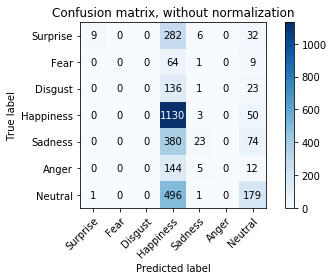

In [25]:
plot_confusion_matrix(test_targets, predicted, classes, normalize=False)

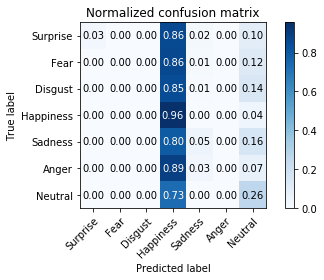

In [26]:
plot_confusion_matrix(test_targets, predicted, classes, normalize=True)

## HDP

In [27]:
train_copus, train_v, train_targets, dct, hdp = build_hdp_vec(train_docs, train_targets)

In [28]:
test_copus, test_v, test_targets, dct, hdp = build_hdp_vec(test_docs, test_targets, dct, hdp)

### result for NB

In [29]:
is_use_pre_run = False
# if is_use_pre_run:
#     with open(hdp_nb_clf_pkl, 'rb') as f:
#         clf2 = pickle.load(f)
# else:
clf2 = MultinomialNB().fit(train_v, train_targets)
with open('hdp_nb_clf.pkl', 'wb') as f:
    pickle.dump(clf2, f)
        
predicted = clf2.predict(test_v)
np.mean(predicted == test_targets) 

0.3988892518784711

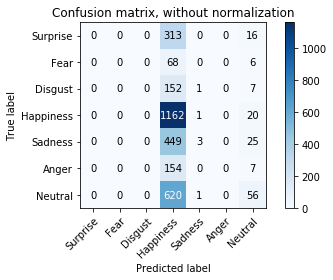

In [30]:
_ = plot_confusion_matrix(test_targets, predicted, classes, normalize=False)

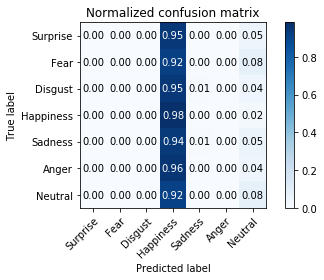

In [31]:
_ = plot_confusion_matrix(test_targets, predicted, classes, normalize=True)

### result for SVM

In [32]:
if is_use_pre_run:
    with open(hdp_svm_clf_pkl, 'rb') as f:
        clf2 = pickle.load(f)
else:
    clf2 = sklearn.svm.SVC(gamma='scale', coef0=4).fit(train_v, train_targets)
    with open('hdp_svm_clf.pkl', 'wb') as f:
        pickle.dump(clf2, f)

predicted = clf2.predict(test_v)
np.mean(predicted == test_targets) 

0.4011760862463247

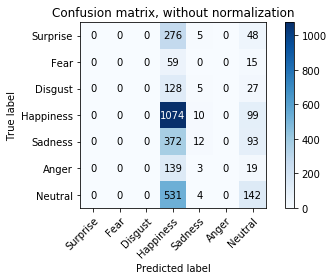

In [33]:
_ = plot_confusion_matrix(test_targets, predicted, classes, normalize=False)

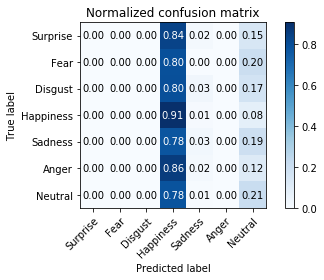

In [34]:
_ = plot_confusion_matrix(test_targets, predicted, classes, normalize=True)

In [35]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)

In [36]:
clf.fit(train_v, train_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [37]:
predicted = clf.predict(test_v)
np.mean(predicted == test_targets) 

0.3864750081672656

### RF

In [38]:
clf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=0)

In [39]:
clf.fit(X_train_tf, train_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [40]:
predicted = clf.predict(X_test_tf)
np.mean(predicted == test_targets) 

0.4380921267559621

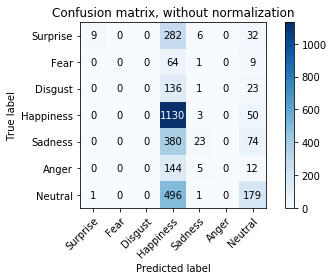

In [41]:
plot_confusion_matrix(test_targets, predicted, classes, normalize=False)

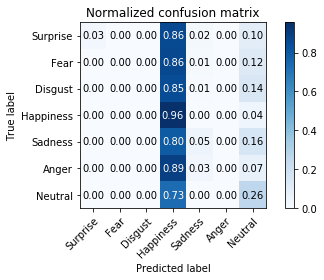

In [42]:
plot_confusion_matrix(test_targets, predicted, classes, normalize=True)